In [ ]:
from pathlib import Path
import sys

current_path = Path.cwd()
project_root = current_path
while not (project_root / "src").exists() and project_root != project_root.parent:
    project_root = project_root.parent

if not (project_root / "src").exists():
    project_root = Path.cwd().parent

src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

Project root: i:\Winter-Break-Research
Loading config from: i:\Winter-Break-Research\configs\data.yaml
Validation summary saved to: i:\Winter-Break-Research\results\data_validation_week1.json
Downloaded price frame shape: (2768, 28)
Validation summary saved to: i:\Winter-Break-Research\results\data_validation_week1.json
Downloaded price frame shape: (2768, 28)


Ticker,XLK,IYW,XLF,VFH,XLE,XLY,XLV,XLI,XLP,XLB,...,SMH,SOXX,IBB,EEM,EFA,TLT,HYG,LQD,DIA,IWM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,30.534748,20.073288,14.189486,34.705326,55.728367,58.185116,45.555267,41.595531,31.120235,36.220379,...,18.562838,20.980490,73.682411,31.217636,46.874805,74.395241,49.648827,76.185196,128.870743,97.860039
2014-01-03,30.388073,19.983850,14.287385,34.893711,55.523972,58.027676,45.662697,41.708542,31.061596,36.133499,...,18.505367,20.919046,73.338478,31.163263,46.924580,74.395241,49.632832,76.298340,129.090698,98.357430
2014-01-06,30.336309,19.958614,14.300443,34.932976,55.600620,57.669037,45.472637,41.466389,30.944281,35.935989,...,18.386005,20.816647,72.621429,30.868097,46.867680,74.708290,49.739548,76.464752,128.697998,97.559875
2014-01-07,30.612406,20.153547,14.306968,34.995796,56.022175,58.018917,45.951927,41.724689,31.112907,35.872791,...,18.447899,20.960016,73.630524,31.000158,47.130829,74.897652,49.739548,76.404877,129.546082,98.374557
2014-01-08,30.612406,20.171896,14.352658,35.066422,55.632542,57.861477,46.356804,41.652050,30.878323,36.086082,...,18.646833,21.273062,75.139275,30.899179,47.116611,74.693779,49.707516,76.078575,129.059235,98.503204


{'n_rows': 2768,
 'n_cols': 28,
 'missing_pct': {'XLK': 0.0,
  'IYW': 0.0,
  'XLF': 0.0,
  'VFH': 0.0,
  'XLE': 0.0,
  'XLY': 0.0,
  'XLV': 0.0,
  'XLI': 0.0,
  'XLP': 0.0,
  'XLB': 0.0,
  'SPY': 0.0,
  'QQQ': 0.0,
  'XLU': 0.0,
  'XLC': 0.4057,
  'XOP': 0.0,
  'XME': 0.0,
  'ITB': 0.0,
  'XHB': 0.0,
  'SMH': 0.0,
  'SOXX': 0.0,
  'IBB': 0.0,
  'EEM': 0.0,
  'EFA': 0.0,
  'TLT': 0.0,
  'HYG': 0.0,
  'LQD': 0.0,
  'DIA': 0.0,
  'IWM': 0.0},
 'extreme_moves': {'XLK': 0,
  'IYW': 0,
  'XLF': 0,
  'VFH': 0,
  'XLE': 2,
  'XLY': 0,
  'XLV': 0,
  'XLI': 0,
  'XLP': 0,
  'XLB': 0,
  'SPY': 0,
  'QQQ': 0,
  'XLU': 0,
  'XLC': 0,
  'XOP': 3,
  'XME': 0,
  'ITB': 2,
  'XHB': 2,
  'SMH': 0,
  'SOXX': 1,
  'IBB': 0,
  'EEM': 0,
  'EFA': 0,
  'TLT': 0,
  'HYG': 0,
  'LQD': 0,
  'DIA': 0,
  'IWM': 0},
 'all_nan_columns': []}

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pairs_trading_etf.data.ingestion import download_etf_data, save_raw_data, validate_price_data
from pairs_trading_etf.utils.config import load_yaml_config

CONFIG_PATH = project_root / "configs" / "data.yaml"
RAW_OUTPUT = project_root / "data" / "raw" / "etf_prices.csv"
RESULTS_DIR = project_root / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = RESULTS_DIR / "figures" / "week1"
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
COINTEG_HEATMAP_PATH = FIGURES_DIR / "week1_cointegration_corr_heatmap.png"
HIGH_CORR_TABLE_PATH = RESULTS_DIR / "week1_high_corr_pairs.csv"

print(f"Project root: {project_root}")
print(f"Loading config from: {CONFIG_PATH}")

config = load_yaml_config(CONFIG_PATH)
tickers = config["universe"]["etfs"]
date_cfg = config["data"]

print(f"Downloading data for {tickers} from {date_cfg['start_date']} to {date_cfg['end_date']}...")

prices = download_etf_data(
    tickers=tickers,
    start=date_cfg["start_date"],
    end=date_cfg["end_date"],
)

save_raw_data(prices, RAW_OUTPUT)
summary = validate_price_data(prices)

VALIDATION_PATH = project_root / "results" / "data_validation_week1.json"
VALIDATION_PATH.parent.mkdir(parents=True, exist_ok=True)

with open(VALIDATION_PATH, "w") as f:
    json.dump(summary, f, indent=2)

print(f"Validation summary saved to: {VALIDATION_PATH}")
summary

print(f"Downloaded price frame shape: {prices.shape}")
try:
    display(prices.head())
    display(summary)
except NameError:
    print(prices.head())
    print(summary)

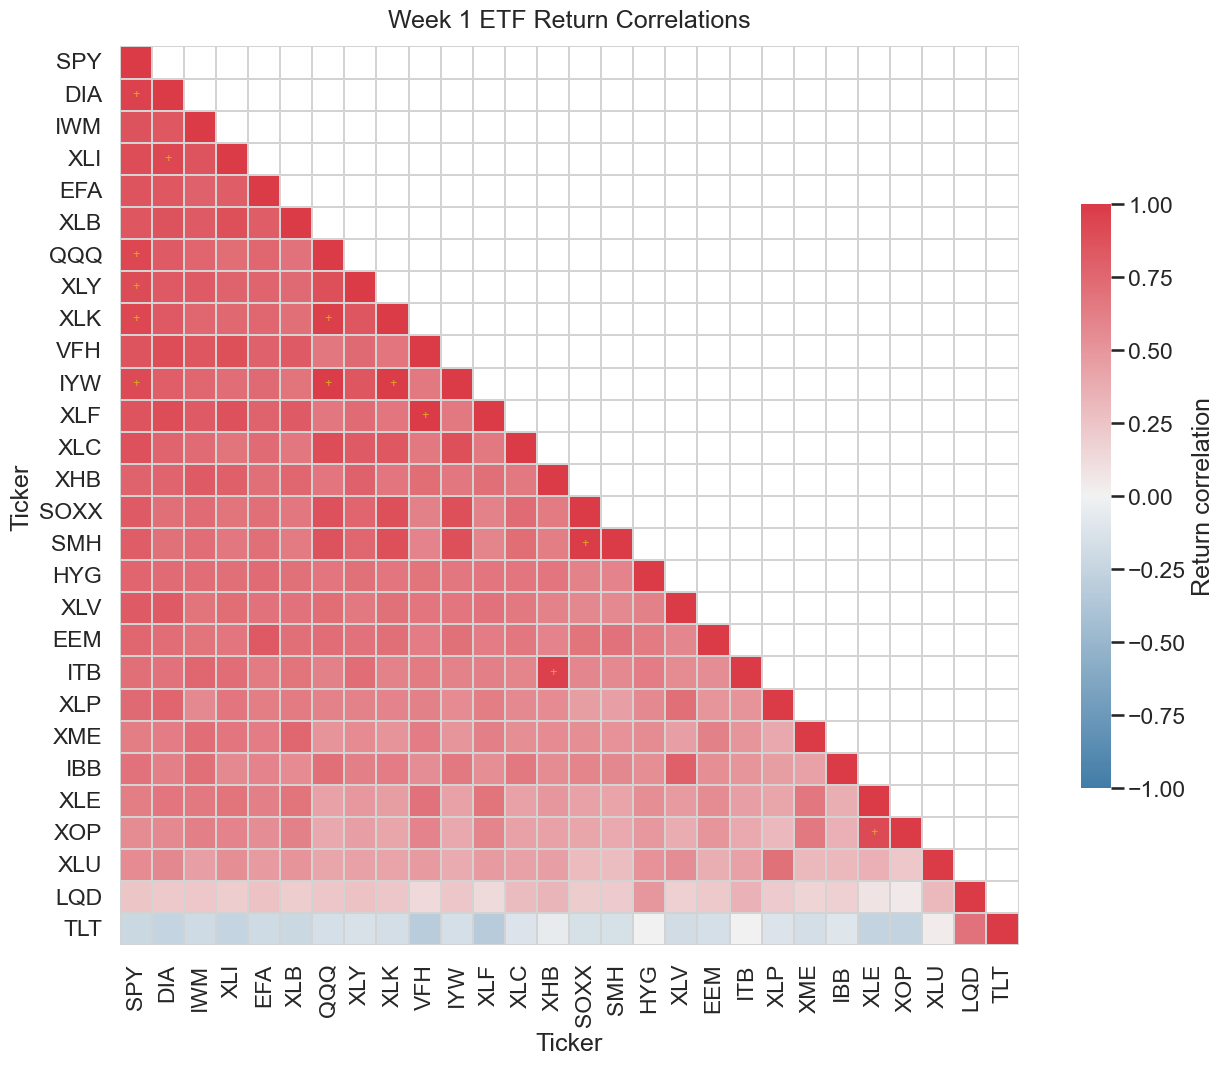

High correlation pairs (> 0.90): 13 found
Top correlation table saved to i:\Winter-Break-Research\results\week1_high_corr_pairs.csv


,ticker_x,ticker_y,correlation
rank,,,
1,VFH,XLF,0.993
2,SOXX,SMH,0.989
3,XLK,IYW,0.988
4,QQQ,IYW,0.983
5,QQQ,XLK,0.973
6,XHB,ITB,0.963
7,SPY,DIA,0.954
8,SPY,QQQ,0.929
9,DIA,XLI,0.929


In [ ]:
sns.set_theme(style="white", context="talk")

# Compute correlation matrix using returns (prices are non-stationary)
returns = prices.pct_change().dropna(how="all")
corr_matrix = returns.corr()

# Order tickers by average absolute correlation for a cleaner visual grouping
sorted_idx = corr_matrix.abs().mean().sort_values(ascending=False).index
corr_matrix = corr_matrix.loc[sorted_idx, sorted_idx]

# Mask the upper triangle to reduce clutter with larger universes
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
lower_mask = ~mask
np.fill_diagonal(lower_mask, False)

fig, ax = plt.subplots(figsize=(14, 11))
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=cmap,
    vmin=-1,
    vmax=1,
    center=0,
    cbar_kws={"shrink": 0.65, "label": "Return correlation"},
    square=True,
    linewidths=0.25,
    linecolor="lightgray",
    ax=ax,
    xticklabels=True,
    yticklabels=True,
 )
highlight_threshold = 0.9
highlight_mask = (corr_matrix.values >= highlight_threshold) & lower_mask
for y_idx, x_idx in np.argwhere(highlight_mask):
    ax.text(x_idx + 0.5, y_idx + 0.5, "+", color="goldenrod", ha="center", va="center", fontsize=9)
ax.set_title("Week 1 ETF Return Correlations", pad=14)
ax.tick_params(axis="x", labelrotation=90)
ax.tick_params(axis="y", labelrotation=0)
fig.tight_layout()
fig.savefig(COINTEG_HEATMAP_PATH, dpi=150, bbox_inches="tight")
plt.show()

# Vectorized extraction of high-correlation pairs
threshold = highlight_threshold
upper_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
high_corr_df = (
    corr_matrix.mask(~upper_mask)
    .stack()
    .rename_axis(("ticker_x", "ticker_y"))
    .reset_index(name="correlation")
)
high_corr_df = high_corr_df[high_corr_df["correlation"] >= threshold].sort_values(
    "correlation", ascending=False
)

# Maintain legacy list for later cells that expect tuples
high_corr_pairs = list(
    high_corr_df[["ticker_x", "ticker_y", "correlation"]].itertuples(index=False, name=None)
)

print(f"High correlation pairs (> {threshold:.2f}): {len(high_corr_df)} found")
if high_corr_df.empty:
    print("No pairs cleared the threshold; consider lowering it or expanding the lookback window.")
else:
    high_corr_df.to_csv(HIGH_CORR_TABLE_PATH, index=False)
    print(f"Top correlation table saved to {HIGH_CORR_TABLE_PATH}")
    styled_pairs = (
        high_corr_df.head(20)
        .assign(rank=lambda df: np.arange(1, len(df) + 1))
        .set_index("rank")
        .style.format({"correlation": "{:.3f}"}).background_gradient("Reds", subset=["correlation"])
)
    display(styled_pairs)

In [ ]:
min_series = 3
available = prices.columns.tolist()
if len(available) < min_series:
    print("Need at least three tickers to run the Johansen test.")
else:
    ordered = []
    if high_corr_pairs:
        for t1, t2, _ in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
            for ticker in (t1, t2):
                if ticker not in ordered:
                    ordered.append(ticker)
            if len(ordered) >= min_series:
                break
    if len(ordered) < min_series:
        for ticker in tickers:
            if ticker not in ordered:
                ordered.append(ticker)
            if len(ordered) >= min_series:
                break

    johansen_tickers = ordered[:min_series]
    levels = prices[johansen_tickers].dropna()
    log_levels = np.log(levels.where(levels > 0)).dropna()

    johansen_res = coint_johansen(log_levels, det_order=0, k_ar_diff=1)
    trace_df = pd.DataFrame(
        {
            "trace_stat": johansen_res.lr1,
            "crit_90": johansen_res.cvt[:, 0],
            "crit_95": johansen_res.cvt[:, 1],
            "crit_99": johansen_res.cvt[:, 2],
        },
        index=[f"r <= {i}" for i in range(len(johansen_res.lr1))],
    )

    print(f"Johansen trace test for tickers: {', '.join(johansen_tickers)}")
    display(trace_df.round(3))

Johansen trace test for tickers: VFH, XLF, SOXX


,trace_stat,crit_90,crit_95,crit_99
r <= 0,34.926,27.067,29.796,35.463
r <= 1,10.675,13.429,15.494,19.935
r <= 2,0.936,2.706,3.842,6.635


## Next steps
- [x] Compute correlation matrix & visualize via heatmap.
- [x] Run rolling correlation to identify stable relationships.
- [x] Implement Engle–Granger two-step test for top candidate pairs.
- [x] Validate cointegration hits with Johansen test (if multivariate).

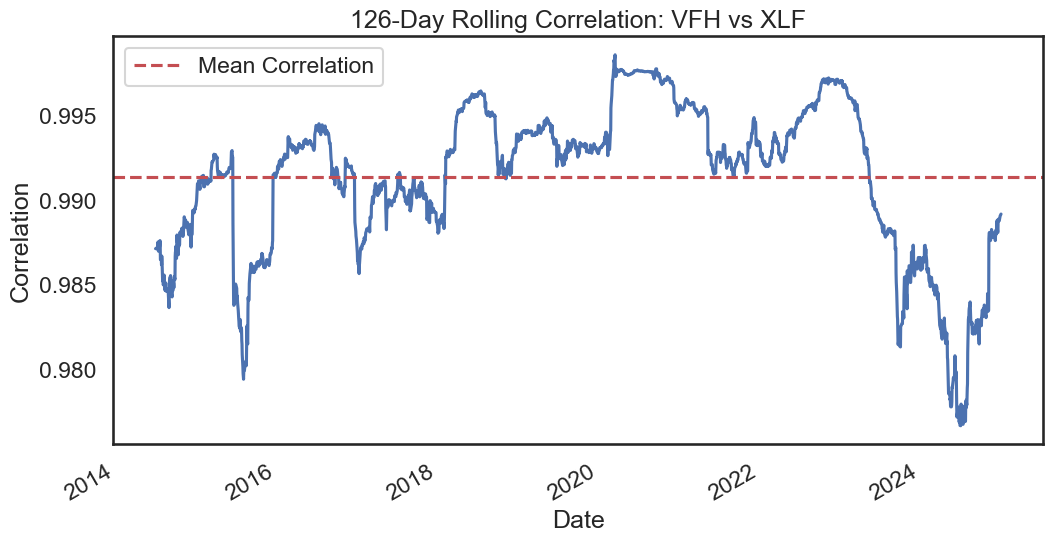

In [4]:
# Rolling correlation analysis for the top pair
# This helps check if the relationship is stable over time or just a temporary regime

if "high_corr_pairs" in globals() and high_corr_pairs:
    # Pick the pair with the highest correlation
    top_pair = sorted(high_corr_pairs, key=lambda x: x[2], reverse=True)[0]
    t1, t2, _ = top_pair
    
    window = 126 # Approx 6 months of trading days
    rolling_corr = returns[t1].rolling(window=window).corr(returns[t2])
    
    plt.figure(figsize=(12, 6))
    rolling_corr.plot(title=f'{window}-Day Rolling Correlation: {t1} vs {t2}')
    plt.axhline(rolling_corr.mean(), color='r', linestyle='--', label='Mean Correlation')
    plt.legend()
    plt.ylabel('Correlation')
    plt.show()
else:
    print("No high correlation pairs found to analyze.")